In [ ]:
# Import libraries yang diperlukan
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [ ]:
# [STEP 1] Mount Google Drive untuk mengakses dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# [STEP 2] Definisikan dataset custom untuk Cityscapes

class CityscapesDataset(Dataset):
    """
    Custom dataset untuk mengakses data Cityscapes yang telah dipersiapkan.
    Dataset berisi gambar dan mask (anotasi) untuk semantic segmentation.
    """
    def __init__(self, root_dir, split='train', transform=None):
        """
        Inisialisasi dataset

        Args:
            root_dir: Path ke direktori utama dataset
            split: 'train' atau 'test'
            transform: Transformasi untuk gambar input
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        # Set path direktori berdasarkan split (train/test)
        if split == 'train':
            self.img_dir = os.path.join(root_dir, 'images_prepped_train-20230811T065243Z-001/images_prepped_train')
            self.mask_dir = os.path.join(root_dir, 'annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train')
        else:
            self.img_dir = os.path.join(root_dir, 'images_prepped_test-20230811T065241Z-001/images_prepped_test')
            self.mask_dir = os.path.join(root_dir, 'annotations_prepped_test-20230811T065240Z-001/annotations_prepped_test')

        # Temukan file yang ada di kedua direktori (gambar dan mask)
        image_files = set(os.listdir(self.img_dir))
        mask_files = set(os.listdir(self.mask_dir))
        self.images = sorted(list(image_files.intersection(mask_files)))

        print(f"{split} dataset: {len(self.images)} file valid ditemukan")

    def __len__(self):
        """Mengembalikan jumlah sampel dalam dataset"""
        return len(self.images)

    def __getitem__(self, idx):
        """Mengambil satu sampel dari dataset berdasarkan indeks"""
        # Ambil nama file dan buat path lengkap
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        # Verifikasi file ada
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"File gambar tidak ditemukan: {img_path}")
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"File mask tidak ditemukan: {mask_path}")

        # Baca gambar dan mask
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)

        # Resize mask agar ukurannya sama dengan gambar yang ditransformasi
        # Gunakan NEAREST untuk mempertahankan nilai label
        mask = mask.resize((512, 256), Image.NEAREST)

        # Terapkan transformasi pada gambar
        if self.transform:
            image = self.transform(image)

        # Konversi mask ke tensor dan ambil channel pertama jika perlu
        mask = torch.from_numpy(np.array(mask))
        if len(mask.shape) == 3:
            mask = mask[:, :, 0]  # Semua channel sama, ambil yang pertama

        # Konversi ke tipe Long untuk CrossEntropyLoss
        mask = mask.long()

        return image, mask

In [ ]:
# [STEP 3] Buat transformasi untuk gambar input
# Resize ke ukuran yang konsisten, konversi ke tensor, dan normalisasi
transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# [STEP 4] Inisialisasi dataset dan dataloader
# Set path dataset
data_root = '/content/drive/MyDrive/Course CV Indonesia AI/project 3 : self-driving car/dataset cityscapes'

# Buat dataset untuk training dan testing
train_dataset = CityscapesDataset(root_dir=data_root, split='train', transform=transform)
test_dataset = CityscapesDataset(root_dir=data_root, split='test', transform=transform)

# Periksa ukuran dataset
print(f"Jumlah data training: {len(train_dataset)}")
print(f"Jumlah data testing: {len(test_dataset)}")

# Cek salah satu sampel data
image, mask = train_dataset[0]
print(f"Ukuran gambar: {image.shape}")
print(f"Ukuran mask: {mask.shape}")
print(f"Nilai unik pada mask: {torch.unique(mask)}")

train dataset: 367 file valid ditemukan
test dataset: 101 file valid ditemukan
Jumlah data training: 367
Jumlah data testing: 101
Ukuran gambar: torch.Size([3, 256, 512])
Ukuran mask: torch.Size([256, 512])
Nilai unik pada mask: tensor([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 11])


Image shape: torch.Size([3, 256, 512]), Mask shape: torch.Size([256, 512])


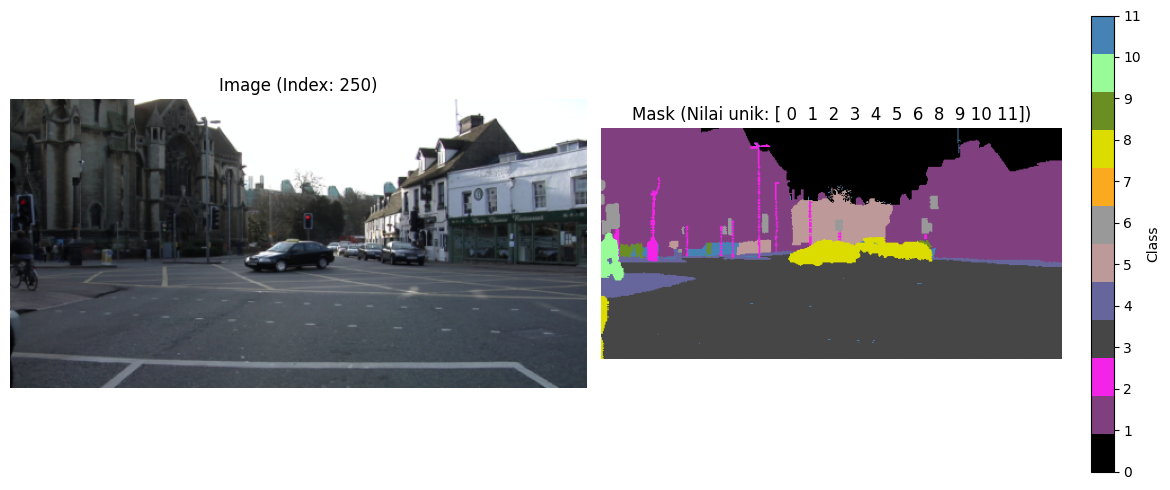

Sampel yang divisualisasikan adalah indeks: 250


In [ ]:
# [STEP 5] Visualisasi Dataset
# Definisikan warna untuk setiap kelas dalam dataset
cityscapes_colors = [
    (0, 0, 0),        # 0: Background (hitam)
    (128, 64, 128),   # 1: Road (ungu)
    (244, 35, 232),   # 2: Sidewalk (pink)
    (70, 70, 70),     # 3: Building (abu-abu gelap)
    (102, 102, 156),  # 4: Wall (lavender)
    (190, 153, 153),  # 5: Fence (beige)
    (153, 153, 153),  # 6: Pole (abu-abu terang)
    (250, 170, 30),   # 7: Traffic Light (oranye)
    (220, 220, 0),    # 8: Traffic Sign (kuning)
    (107, 142, 35),   # 9: Vegetation (hijau)
    (152, 251, 152),  # 10: Terrain (hijau terang)
    (70, 130, 180)    # 11: Sky (biru)
]

# Normalisasi warna untuk matplotlib (0-1 range)
cityscapes_colors_normalized = [(r/255, g/255, b/255) for r, g, b in cityscapes_colors]

# Fungsi untuk visualisasi dataset
def visualize_sample(dataset, idx=None, class_colors=None):
    """Visualisasi sampel dari dataset"""
    if idx is None:
        idx = random.randint(0, len(dataset)-1)

    image, mask = dataset[idx]

    # Print shapes untuk verifikasi
    print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")

    # Konversi tensor gambar ke numpy untuk visualisasi
    # Denormalisasi gambar
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Image sudah berupa tensor dengan shape (3, H, W)
    image_np = image.numpy().transpose(1, 2, 0)
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)

    # Konversi mask tensor ke numpy
    mask_np = mask.numpy()

    # Set color map untuk mask
    if class_colors is None:
        # Cmap default jika tidak ada pemetaan warna yang diberikan
        cmap = plt.cm.get_cmap('tab10', 12)  # 12 kelas (0-11)
    else:
        # Jika ada pemetaan warna kustom
        cmap = plt.matplotlib.colors.ListedColormap(class_colors)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title(f'Image (Index: {idx})')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap=cmap, vmin=0, vmax=11)
    plt.title(f'Mask (Nilai unik: {np.unique(mask_np)})')
    plt.axis('off')
    plt.colorbar(ticks=np.arange(12), label='Class')

    plt.tight_layout()
    plt.show()

    return idx

# Visualisasi sampel random
random_idx = visualize_sample(train_dataset, class_colors=cityscapes_colors_normalized)
print(f"Sampel yang divisualisasikan adalah indeks: {random_idx}")

# Buat dataloader untuk batch processing
batch_size = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

In [ ]:
# [STEP 6] Definisikan komponen-komponen dan model U-Net

# Double Convolution Block
class DoubleConv(nn.Module):
    """Block dengan dua conv layers + batch norm + ReLU"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Down-sampling block
class Down(nn.Module):
    """Maxpool diikuti oleh double convolution"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

# Up-sampling block
class Up(nn.Module):
    """Upscaling kemudian double conv dengan skip connection"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        # Pilihan upsampling: bilinear interpolation atau transposed conv
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Atasi perbedaan ukuran dengan padding
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        # Concatenate hasil upsampling dengan skip connection
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Output convolution
class OutConv(nn.Module):
    """Convolution 1x1 untuk output"""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Definisi model U-Net lengkap
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        """
        U-Net untuk semantic segmentation

        Args:
            n_channels: Jumlah channel input (3 untuk RGB)
            n_classes: Jumlah kelas output (12 untuk dataset ini)
            bilinear: True menggunakan interpolasi bilinear, False menggunakan transposed conv
        """
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Encoder path (contracting path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        # Decoder path (expansive path)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)

        # Final convolution
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Encoder (dan simpan output untuk skip connections)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder dengan skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Output layer
        logits = self.outc(x)
        return logits

In [ ]:
# n_channels=3 (RGB), n_classes=12 (kelas dalam dataset)
model = UNet(n_channels=3, n_classes=12, bilinear=True)

# Pindahkan model ke GPU jika tersedia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Cetak ringkasan model
print(model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [ ]:
# [STEP 8] Definisikan loss function, optimizer, dan metrik evaluasi

# Loss function: CrossEntropyLoss untuk klasifikasi multi-kelas
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler untuk mengurangi learning rate jika performa stagnant
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Fungsi untuk menghitung IoU (Intersection over Union)
def iou_score(pred, target):
    """Hitung mean IoU untuk semua kelas"""
    pred = pred.argmax(dim=1)  # Convert dari one-hot ke indeks kelas

    # Hitung IoU untuk setiap kelas
    ious = []
    for cls in range(12):  # 12 kelas (0-11)
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).sum().float()
        union = (pred_cls | target_cls).sum().float()
        if union > 0:
            iou = (intersection + 1e-6) / (union + 1e-6)
            ious.append(iou.item())

    # Mean IoU
    return sum(ious) / len(ious) if ious else 0.0

In [ ]:
# [STEP 9] Fungsi training untuk satu epoch
def train_epoch(model, loader, optimizer, criterion, device):
    """Train model untuk satu epoch"""
    model.train()
    epoch_loss = 0
    loop = tqdm(loader)

    for batch_idx, (images, masks) in enumerate(loop):
        # Pindahkan data ke device
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress
        epoch_loss += loss.item()
        loop.set_description(f"Loss: {loss.item():.4f}")

    return epoch_loss / len(loader)

In [ ]:
# [STEP 10] Fungsi validasi
def validate(model, loader, criterion, device):
    """Evaluasi model pada data validasi/test"""
    model.eval()
    val_loss = 0
    val_iou = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Hitung metrics
            val_loss += loss.item()
            val_iou += iou_score(outputs, masks)

    return val_loss / len(loader), val_iou / len(loader)

In [ ]:
# [STEP 11] Training loop
# Hyperparameters
num_epochs = 1
train_losses = []
val_losses = []
val_ious = []

best_val_loss = float('inf')
best_model_path = 'best_unet_model.pth'

print(f"Training pada device: {device}")
print(f"Jumlah data training: {len(train_dataset)}")
print(f"Jumlah data testing: {len(test_dataset)}")

# Loop training untuk sejumlah epoch
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train untuk satu epoch
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

    # Validasi model
    val_loss, val_iou = validate(model, test_loader, criterion, device)

    # Update learning rate
    scheduler.step(val_loss)

    # Simpan history untuk plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if isinstance(val_iou, torch.Tensor):
        val_ious.append(val_iou.item())
    else:
        val_ious.append(val_iou)

    # Print progress
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

    # Simpan model terbaik
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Model disimpan ke {best_model_path}")

Training pada device: cpu
Jumlah data training: 367
Jumlah data testing: 101
Epoch 1/1


Loss: 0.7343: 100%|██████████| 92/92 [1:00:40<00:00, 39.57s/it]


Train Loss: 1.0771, Val Loss: 0.9850, Val IoU: 0.2354
Model disimpan ke best_unet_model.pth


In [ ]:
# [STEP 12] Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Kurva Loss')

plt.subplot(1, 2, 2)
plt.plot(val_ious, label='Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()
plt.title('Kurva IoU')

plt.tight_layout()
plt.show()

In [ ]:
# [STEP 13] Fungsi untuk denormalisasi gambar & decode mask

# Fungsi untuk denormalisasi gambar
def denormalize(tensor):
    """Kembalikan tensor gambar ke range [0,1] dari normalisasi ImageNet"""
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    tensor = tensor.clone().detach()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    tensor = tensor.clamp(0, 1)
    return tensor

# Fungsi untuk mengkonversi label ke warna RGB
def decode_segmap(label, n_classes=12):
    """Konversi label mask menjadi gambar RGB berwarna"""
    r = np.zeros_like(label).astype(np.uint8)
    g = np.zeros_like(label).astype(np.uint8)
    b = np.zeros_like(label).astype(np.uint8)

    for i in range(n_classes):
        idx = (label == i)
        r[idx] = cityscapes_colors[i][0]
        g[idx] = cityscapes_colors[i][1]
        b[idx] = cityscapes_colors[i][2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb


In [ ]:
# [STEP 14] Muat model terbaik (jika ada) dan visualisasi hasil prediksi

# Load model terbaik jika ada
try:
    model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded best model from {best_model_path}")
except:
    print("Using current model state (best model not found)")

model.eval()

# Visualisasi hasil prediksi pada sampel random dari test set
num_samples = 10
random_indices = random.sample(range(len(test_dataset)), num_samples)

# Buat figure untuk visualisasi
plt.figure(figsize=(15, 20))

with torch.no_grad():
    for i, idx in enumerate(random_indices):
        # Ambil sampel
        image, true_mask = test_dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension

        # Prediksi
        output = model(image)
        pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        # Convert ke numpy untuk visualisasi
        image = denormalize(image.squeeze().cpu())
        image_np = image.permute(1, 2, 0).numpy()
        true_mask_np = true_mask.cpu().numpy()

        # Decode mask ke RGB
        pred_rgb = decode_segmap(pred_mask)
        true_rgb = decode_segmap(true_mask_np)

        # Plot
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(image_np)
        plt.title(f"Image {idx}")
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(pred_rgb)
        plt.title(f"Prediction")
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(true_rgb)
        plt.title(f"Ground Truth")
        plt.axis('off')

plt.tight_layout()
plt.savefig('segmentation_results.png', bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
# [STEP 15] Evaluasi IoU pada seluruh test set
total_iou = 0
num_batches = 0

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        batch_iou = iou_score(outputs, masks)

        if isinstance(batch_iou, torch.Tensor):
            batch_iou = batch_iou.item()

        total_iou += batch_iou
        num_batches += 1

avg_iou = total_iou / num_batches
print(f"Average IoU pada test set: {avg_iou:.4f}")

print("Eksperimen selesai!")

In [ ]:
import torch
import torch.nn.functional as F

def multiclass_dice_loss(pred, target, smooth=1):
    """
    Computes Dice Loss for multi-class segmentation.
    Args:
        pred: Tensor of predictions (batch_size, C, H, W).
        target: One-hot encoded ground truth (batch_size, C, H, W).
        smooth: Smoothing factor.
    Returns:
        Scalar Dice Loss.
    """
    pred = F.softmax(pred, dim=1)  # Convert logits to probabilities
    num_classes = pred.shape[1]  # Number of classes (C)
    dice = 0  # Initialize Dice loss accumulator

    for c in range(num_classes):  # Loop through each class
        pred_c = pred[:, c]  # Predictions for class c
        target_c = target[:, c]  # Ground truth for class c

        intersection = (pred_c * target_c).sum(dim=(1, 2))  # Element-wise multiplication
        union = pred_c.sum(dim=(1, 2)) + target_c.sum(dim=(1, 2))  # Sum of all pixels

        dice += (2. * intersection + smooth) / (union + smooth)  # Per-class Dice score

    return 1 - dice.mean() / num_classes  # Average Dice Loss across classes

In [ ]:
def dice_coefficient(pred, target):
    pred = torch.argmax(F.softmax(pred, dim=1), dim=1)  # Get class predictions
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection) / (union + 1e-6)
    return dice.item()

model.eval()
for images, masks in val_loader:
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        outputs = model(images)['out']
    dice_score = dice_coefficient(outputs, masks)
    print(f"Dice Coefficient: {dice_score:.4f}")